## Neural Nets for FKD


In [1]:
# initiate packages for NN - Theano etc.
%matplotlib inline

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time
import cPickle as pickle

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
device = theano.config.device # We're using CPUs (for now)
floatConf = theano.config.floatX # Should be 64 bit for CPUs

# due to theano errors, we are forcing this to be float32
'''if (theano.config.floatX == 'float32'):
    floatConf = np.float32
else:
    floatConf = np.float64'''
floatConf = np.float32

np.random.seed(0)

In [28]:
# load data

import sys, os

pathArr = os.getcwd().split("/")
scriptPath = '/'.join(map(str, pathArr[:len(pathArr)-1]))
sys.path.append(scriptPath)

# import submit module from our tools subfolder
from tools import submit, getdata, save4later

In [2]:
# load data
_loaded = getdata.load_data(0, test=True, nonas=True)

FEATURES = _loaded['features']
print 'Number of features:', len(FEATURES)

# load and scale pixel values to [0, 1]
train_data = np.vstack(_loaded['training']['data']) / 255.
train_data = train_data.astype(floatConf)

# load and scale target coordinates to [-1, 1]
train_labels = _loaded['training']['labels']
train_labels = (train_labels - 48) / 48
train_labels = train_labels.astype(floatConf)
    
print 'Training dataset size: ', train_data.shape

test_data = np.vstack(_loaded['test']['data']) / 255.
test_data = test_data.astype(floatConf)

print 'Test dataset size: ', test_data.shape

Number of features: 30
Training dataset size:  (2140, 9216)
Test dataset size:  (1783, 9216)


In [27]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
def NNFunc(data, label):
    net1 = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 9216),  
        hidden_num_units=100,
        output_nonlinearity=None, 
        output_num_units=30,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,

        regression=True,  # flag to indicate we're dealing with regression problem
        max_epochs=400,  # we want to train this many epochs
        verbose=0,
        )
    net1.fit(data, label)
    return net1


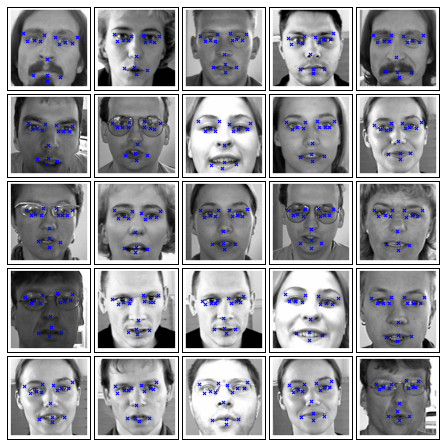

In [20]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

y_pred = net1.predict(train_data)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_sample(train_data[i], y_pred[i], ax)

plt.show()

In [24]:
def get_NN_accuracy(y_pred, train_labels, verbose=False, ret_acc=True):
    ''' Calculates the accuracy for given predicted and labels data '''
    if verbose:
        print "{:30} Accuracy".format("Model")
    
    acc_list = []
    
    for index in range(y_pred.shape[1]):
        accuracy = np.mean(1 - abs(train_labels[:,index] - y_pred[:,index])/ 2)
        acc_list.append(accuracy)

        if verbose:
            print " - {f:<27} {a:.3%}".format(f=FEATURES[index],a=accuracy)
    
    if ret_acc:
        return acc_list

In [29]:
nnOrigData = NNFunc(train_data, train_labels)
save4later.save_model(nnOrigData, "nnOrigData", "NN on Original Data")


    STORED MODELS
 Total: 2

  + MultinomialNB.pk : Multinomial naive bayes with non-preprocessed data with no NAs
  + nnOrigData.pk : NN on Original Data


In [34]:
get_NN_accuracy(nnOrigData.predict(train_data), train_labels, verbose=True)

Model                          Accuracy
 - left_eye_center_x           97.985%
 - left_eye_center_y           98.641%
 - right_eye_center_x          98.269%
 - right_eye_center_y          98.310%
 - left_eye_inner_corner_x     98.131%
 - left_eye_inner_corner_y     98.669%
 - left_eye_outer_corner_x     98.197%
 - left_eye_outer_corner_y     98.424%
 - right_eye_inner_corner_x    98.265%
 - right_eye_inner_corner_y    98.661%
 - right_eye_outer_corner_x    98.330%
 - right_eye_outer_corner_y    98.492%
 - left_eyebrow_inner_end_x    98.126%
 - left_eyebrow_inner_end_y    98.067%
 - left_eyebrow_outer_end_x    97.833%
 - left_eyebrow_outer_end_y    97.857%
 - right_eyebrow_inner_end_x   97.986%
 - right_eyebrow_inner_end_y   97.485%
 - right_eyebrow_outer_end_x   97.730%
 - right_eyebrow_outer_end_y   97.511%
 - nose_tip_x                  97.898%
 - nose_tip_y                  96.765%
 - mouth_left_corner_x         97.779%
 - mouth_left_corner_y         97.648%
 - mouth_right_corner_x 

[0.97984717145319911,
 0.9864066965859537,
 0.98269105455577965,
 0.98309615657448524,
 0.9813134205618842,
 0.98668740313339409,
 0.98196546320718536,
 0.98423963358955768,
 0.98264851071252723,
 0.98661424669016584,
 0.98329518974952179,
 0.98492077080892226,
 0.98125746010026049,
 0.98066600939065063,
 0.9783339709342308,
 0.97856832025327989,
 0.97986115347088321,
 0.9748542275161991,
 0.97729680445553058,
 0.97511243647156465,
 0.97897588902073818,
 0.96765294820231895,
 0.97778904451892867,
 0.97648184594940768,
 0.97834401422629425,
 0.97519568942016077,
 0.98573257026745242,
 0.96774817094797538,
 0.98583908939124609,
 0.9661779846926204]